# Load Spark

In [0]:
# Install latest version of spark. If error, check the latest and replace "spark-2.4.4"
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
import findspark
findspark.init()

In [0]:
#The entry point to using Spark SQL is an object called SparkSession. 
#It initiates a Spark Application which all the code for that Session will run on.
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

In [3]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1. Data loading

In [0]:
DATA_PATH = "/content/gdrive/My Drive/BigData/q1/adult_data.csv"

In [22]:
data = spark.read.csv(DATA_PATH,inferSchema=True, header=False)
print(data.count(),len(data.columns))
data.show(5)

32561 15
+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-------+------+----+----+--------------+------+
|_c0|              _c1|     _c2|       _c3| _c4|                _c5|               _c6|           _c7|   _c8|    _c9|  _c10|_c11|_c12|          _c13|  _c14|
+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-------+------+----+----+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|2174.0| 0.0|40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|   0.0| 0.0|13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad| 9.0|           Divorced| Handlers-cleaners| Not-in-family| White|   Male|   0.0| 0.0|40.0| United-States| <=50K|
| 53|          Private|234721.0|      11th| 7.0| 

In [23]:
col_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
             "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
             "hours_per_week", "native_country", "income"]
print(len(col_names))
data = data.toDF(*col_names)
data.show(5)

15
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad|    

In [24]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [0]:
cols = data.columns

# 2. Data preprocessing
用ML Pipelines 和Feature Transformers 将categorical variables into numeric variables 。可能用到OneHotEncoderEstimator, StringIndexer, 和 VectorAssembler。将数据分成training set and test setwith ratio of 70% and 30% and set the seed to 100.

https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

In [0]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital_status','occupation','relationship',
                     'race','sex','native_country','income']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]



In [27]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
data = pipelineModel.transform(data)


selectedCols = ['label', 'features'] + cols
data = data.select(selectedCols)
data.printSchema()



root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [28]:
pd.DataFrame(data.take(5), columns=data.columns).transpose()

train, test = data.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 22838
Test Dataset Count: 9723


In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)



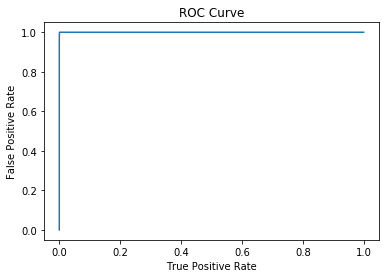

Training set areaUnderROC: 0.999990732486569


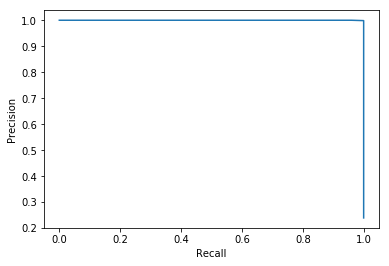

Test Area Under ROC 1.0


In [31]:
import matplotlib.pyplot as plt
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

predictions = lrModel.transform(test)
#predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

,

# 3. 建模：（10％）
用训练集训练逻辑回归模型->predict if an
individual earns less than 50K or larger than 50k per year. It is natural to formulate the problem into binary classification.。在Spark MLlib中了解有关模型提供的更多信息。训练后，绘制训练过程的ROC曲线和Precision-Recall曲线。

# 4. 评价：（10％）
将模型应用于测试集。提供ROC下的面积值，准确性和混淆矩阵。您应该期望精度在85％。

### test class script

In [0]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

sentenceDataFrame = spark.createDataFrame([
    (0,'Hi I heard about Spark'),
    (1, 'I wish'),
    (2, 'Logistic, regression-models')
], ["id", "sentence"])

tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
regexTokenizer = RegexTokenizer(inputCol="sentence", outputCol="words", pattern="\\W")

countTokens = udf(lambda words: len(words), IntegerType())

tokenized = tokenizer.transform(sentenceDataFrame)
tokenized.select("sentence","words").withColumn("tokens", countTokens(col("words"))).show(truncate=False)

regexTokenized = regexTokenizer.transform(sentenceDataFrame)
regexTokenized.select("sentence","words").withColumn("tokens", countTokens(col("words"))).show(truncate=False)

+---------------------------+------------------------------+------+
|sentence                   |words                         |tokens|
+---------------------------+------------------------------+------+
|Hi I heard about Spark     |[hi, i, heard, about, spark]  |5     |
|I wish                     |[i, wish]                     |2     |
|Logistic, regression-models|[logistic,, regression-models]|2     |
+---------------------------+------------------------------+------+

+---------------------------+------------------------------+------+
|sentence                   |words                         |tokens|
+---------------------------+------------------------------+------+
|Hi I heard about Spark     |[hi, i, heard, about, spark]  |5     |
|I wish                     |[i, wish]                     |2     |
|Logistic, regression-models|[logistic, regression, models]|3     |
+---------------------------+------------------------------+------+



In [0]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
remover.transform(tokenized).show(truncate=False)
remover.transform(regexTokenized).show(truncate=False)

+---+---------------------------+------------------------------+------------------------------+
|id |sentence                   |words                         |filtered                      |
+---+---------------------------+------------------------------+------------------------------+
|0  |Hi I heard about Spark     |[hi, i, heard, about, spark]  |[hi, heard, spark]            |
|1  |I wish                     |[i, wish]                     |[wish]                        |
|2  |Logistic, regression-models|[logistic,, regression-models]|[logistic,, regression-models]|
+---+---------------------------+------------------------------+------------------------------+

+---+---------------------------+------------------------------+------------------------------+
|id |sentence                   |words                         |filtered                      |
+---+---------------------------+------------------------------+------------------------------+
|0  |Hi I heard about Spark     |[hi, i